# Data challenge

Your task is to build an algorithm for prohibitory traffic sign recognition. We have
created a training data set (20 images) that can be used for building and fine-tuning a model.
However, you are encouraged to collect more images, since it will allow you to improve your
model’s performance.

There are 6 traffic sign categories your model should be able to recognize:
* Category A - no right, left, or U-turn
* Category B - speed limit (regardless of the indicated value)
* Category C - road closed
* Category D - no entry
* Category E - no stopping, no parking
* Category F - other types of prohibitory traffic signs

## Couple of ideas
We could use the large source of great datasets on Kaggle about traffic signs, these are large enough for buiding a great model but we need to relabel the data for our desired classes.

e.g.
* [GTSRB - German Traffic Sign Recognition Benchmark][1]
* [Traffic Sign Dataset - Classification 🚦🚨🚑🚔🚦🚨🚑🚔🚦🚨🚑🚔][2]
* [Traffic Signs (GTSRB plus 162 custom classes)][3]

[1]: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
[2]: https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification
[3]: https://www.kaggle.com/datasets/daniildeltsov/traffic-signs-gtsrb-plus-162-custom-classes

Possible models to consider are CNNs,[Spatial Transformer Networks][4], [Vision Transformers][5] or whatever comes to your mind. We don't really have to use transformer models I just learned about them recently and I think they are fun. And the [attention mechanism][6] they use is useful if the model needs to focus on specific regions on an image.

[4]: https://arxiv.org/abs/1506.02025
[5]: https://arxiv.org/pdf/2010.11929.pdf
[6]: https://arxiv.org/abs/1706.03762

We should probably use transfer learning starting from a big model that already worked neatly on some big competition.

e.g.

* [VGG16 and VGG19][7]
* [ResNet and ResNetV2][8]
* [google/vit-base-patch16-224-in21k][9]
* [InceptionV3][10]
* [YOLOv8][11]

[7]: https://keras.io/api/applications/vgg/
[8]: https://keras.io/api/applications/resnet/
[9]: https://huggingface.co/google/vit-base-patch16-224-in21k
[10]: https://keras.io/api/applications/inceptionv3/
[11]: https://keras.io/api/keras_cv/models/backbones/yolo_v8/

I'm trying to implement the YOLOv8 model for this task, here are some great resources for it:

* https://yolov8.com/
* https://github.com/ultralytics/ultralytics
* https://docs.ultralytics.com/usage/python/
* https://universe.roboflow.com/rivne-state-humanitarian-university-faculty-of-mathematics-and-information-science/road-sign-detection-gmkcf

Apparently you can only use pytorch for implementing yolov8, but I'm not sure.

In [18]:
!pip install ultralytics    # For using the YOLOv8 model

In [19]:
# import packages
import os
import wandb
import cv2
from PIL import Image, display
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Set CUDA visible devices to GPU 0 and 1 (The 2xT4 GPUs that Kaggle provides)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# Hyperparameters of the model
EPOCHS = 2
EARLY_STOPPING_PATIENCE = None
BATCH_SIZE = 16
FREEZE_LAYERS = 21    # YOLOv8 has 22 layers

# NUmber of training images
TRAIN_IMG_NUM = 20

In [20]:
# Login to Weights & Biases
wandb.login()

run = wandb.init(project='traffic_sign_recognition_data_challenge')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


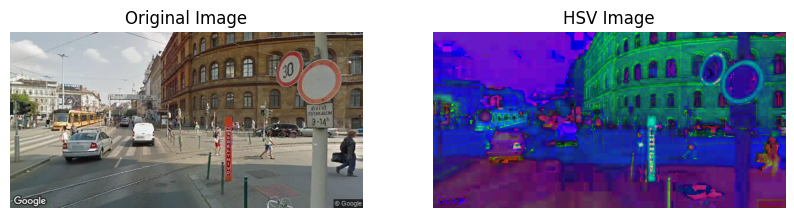

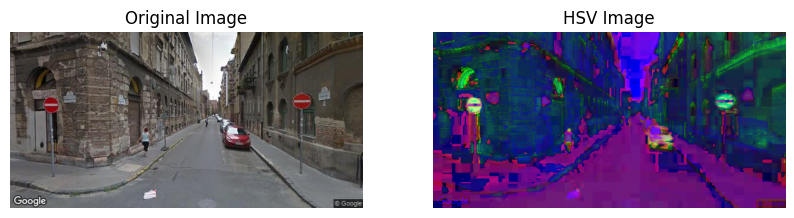

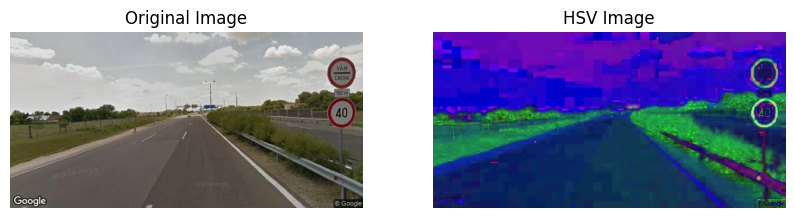

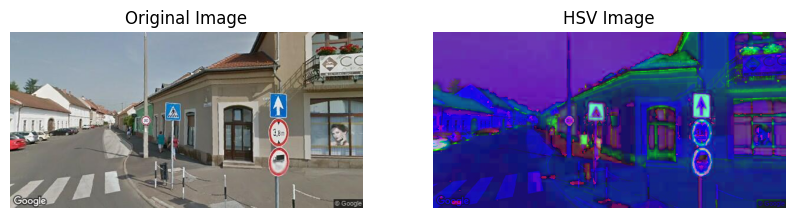

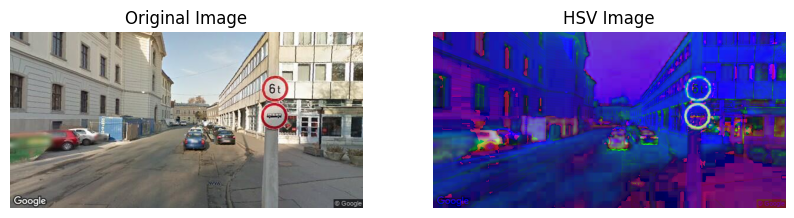

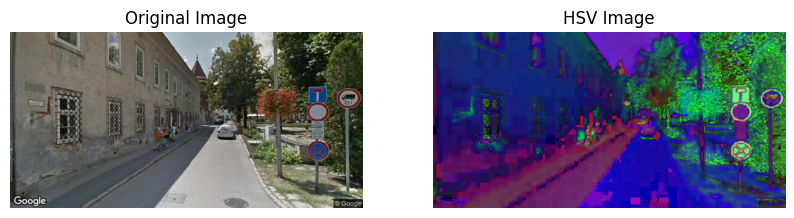

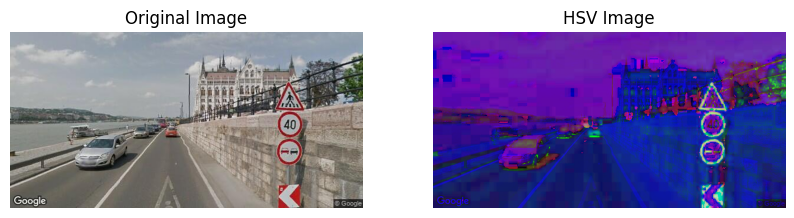

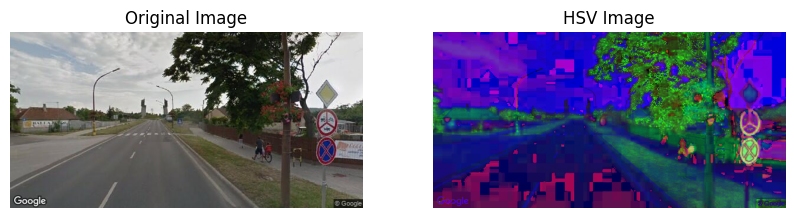

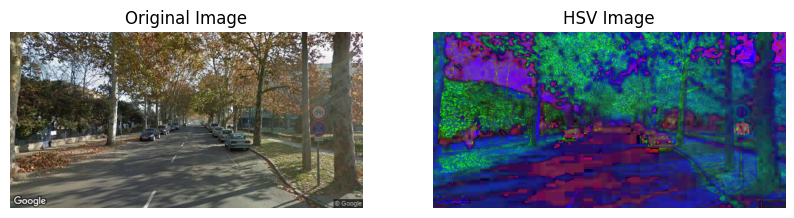

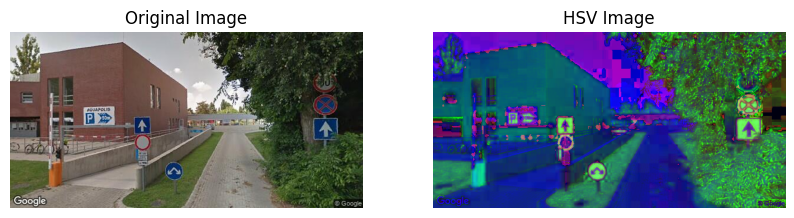

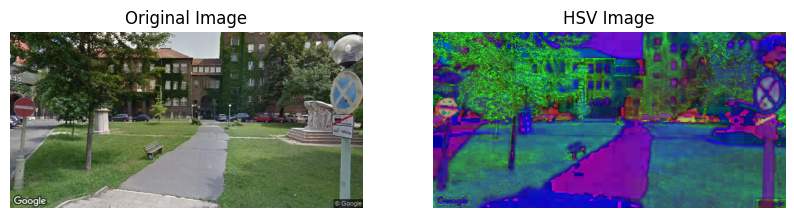

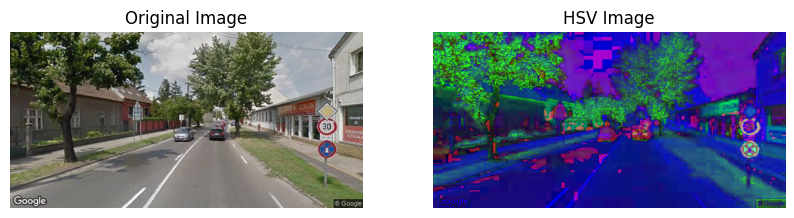

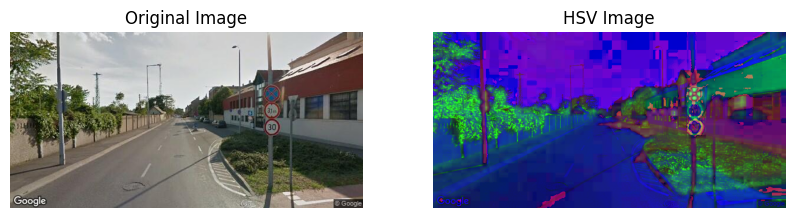

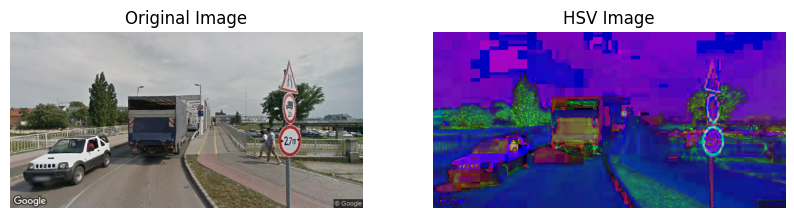

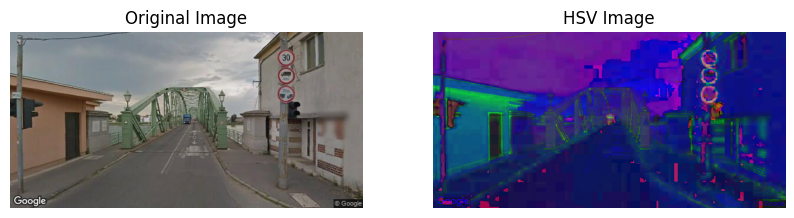

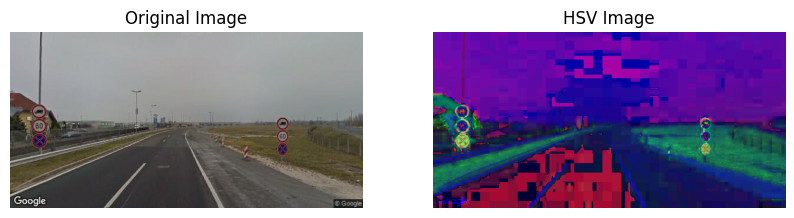

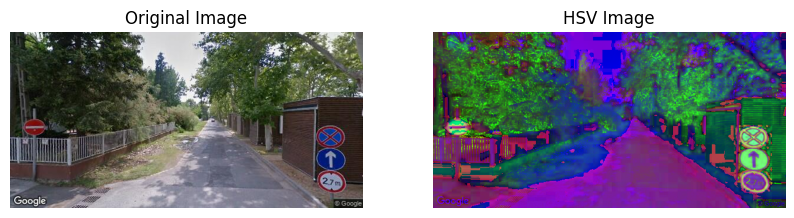

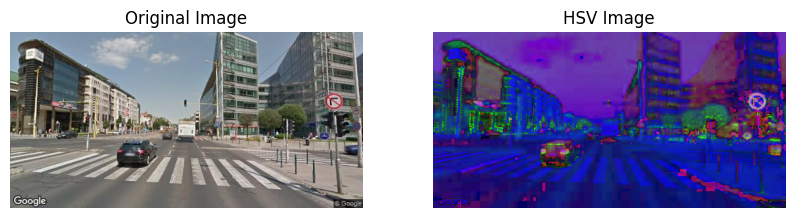

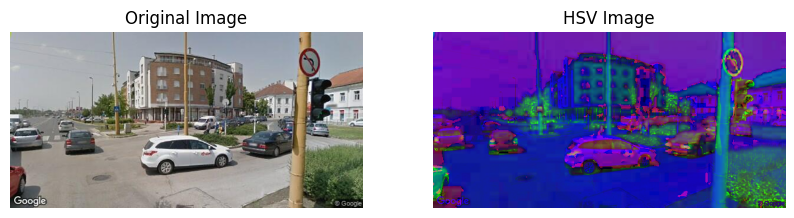

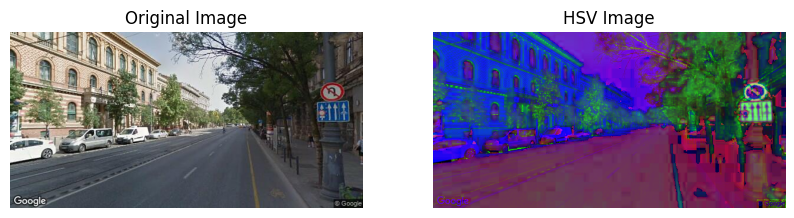

In [21]:
# Display a training image
#for img_num in range(1,TRAIN_IMG_NUM+1):
file_path = '/kaggle/input/traffic/training_images/1.jpg'
# Load the image
image = cv2.imread(file_path)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display the HSV image
plt.subplot(1, 2, 2)
plt.imshow(hsv_image)
plt.title('HSV Image')
plt.axis('off')

plt.show()

## Example usage of the YOLOv8 model.

### You need to have a [Weights & Biases][1] account to run this code. We are using the YOLOv8 model by selecting 'yolov8n.pt'. This model is great at [detection tasks][2]. I recommend browsing though the [docs][3] for the implementation of this model.

[1]: https://wandb.ai/site
[2]: https://docs.ultralytics.com/tasks/detect/
[3]: https://docs.ultralytics.com/

In [22]:
# Load the pretrained model
model = YOLO('yolov8n.pt')

# The wandb magic command displays the details of the run
%wandb

# Train the model with 2 GPUs
results = model.train(project='traffic_sign_recognition_data_challenge',    # wandb project name
                      data='coco128.yaml',                 # Path to data file
                      epochs=EPOCHS,                       # Number of epochs to train for
                      patience=EARLY_STOPPING_PATIENCE,    # Epochs to wait for no observable improvement for early stopping
                      batch=BATCH_SIZE,                    # Number of images per batch
                      freeze=FREEZE_LAYERS,                # Freeze the first n layers
                      imgsz=640,                           # Size of input images (640x640 pixels)
                      device=[0, 1],                       # Run on the 2 T4 GPUs provided by Kaggle
                      seed=42,)                            # Random seed for reproducibility

metrics = model.val()  # evaluate model performance on the validation set
results = model('/kaggle/input/traffic/training_images/1.jpg')  # predict on an image

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    
    im_array = result.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results.jpg')  # save image
    
path = model.export()  # export the model to PYTORCH format

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=2, patience=None, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=traffic_sign_recognition_data_challenge, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=21, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=Fals

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorBoard: Start with 'tensorboard --logdir traffic_sign_recognition_data_challenge/train4', view at http://localhost:6006/


wandb: Currently logged in as: emmermarci (import_this). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231216_123835-pssevzbh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run train4
wandb: ⭐️ View project at https://wandb.ai/import_this/traffic_sign_recognition_data_challenge
wandb: 🚀 View run at https://wandb.ai/import_this/traffic_sign_recognition_data_challenge/runs/pssevzbh


Transferred 355/355 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'model.4.cv1.bn.weight'
Freezing layer 'model.4.cv1.bn.bias'
Freezing layer 'model.4.cv

train: Scanning /kaggle/working/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
val: Scanning /kaggle/working/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to traffic_sign_recognition_data_challenge/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to traffic_sign_recognition_data_challenge/train4
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2     0.698G      1.368      1.931      1.314        174        640: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]


                   all        128        929      0.643      0.524      0.594      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2     0.742G      1.332       1.65      1.316         90        640: 100%|██████████| 8/8 [00:01<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.81it/s]


                   all        128        929      0.656      0.544       0.62      0.456

2 epochs completed in 0.004 hours.
Optimizer stripped from traffic_sign_recognition_data_challenge/train4/weights/last.pt, 6.5MB
Optimizer stripped from traffic_sign_recognition_data_challenge/train4/weights/best.pt, 6.5MB

Validating traffic_sign_recognition_data_challenge/train4/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


                   all        128        929      0.655      0.541       0.62      0.456
                person        128        254      0.826      0.654      0.755      0.541
               bicycle        128          6      0.537      0.333      0.383      0.333
                   car        128         46      0.726      0.217      0.276      0.181
            motorcycle        128          5      0.696          1      0.962       0.77
              airplane        128          6      0.837          1      0.972      0.667
                   bus        128          7      0.577      0.714      0.719      0.574
                 train        128          3       0.56      0.667       0.83      0.698
                 truck        128         12      0.827      0.402      0.461      0.277
                  boat        128          6      0.534      0.333      0.455      0.273
         traffic light        128         14      0.677      0.214      0.208       0.13
             stop sig

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▁█
wandb:                  lr/pg1 ▁█
wandb:                  lr/pg2 ▁█
wandb:        metrics/mAP50(B) ▁█
wandb:     metrics/mAP50-95(B) ▁█
wandb:    metrics/precision(B) ▁█
wandb:       metrics/recall(B) ▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁
wandb:          train/cls_loss █▁
wandb:          train/dfl_loss ▁█
wandb:            val/box_loss █▁
wandb:            val/cls_loss █▁
wandb:            val/dfl_loss █▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 5e-05
wandb:                  lr/pg1 5e-05
wandb:                  lr/pg2 5e-05
wandb:        metrics/mAP50(B) 0.61963
wandb:     metrics/mAP50-95(B) 0.45649
wandb:    metrics/precision(B) 0.65507
wandb:       metrics/recall(B) 0.54104
wandb:            model/GFLOPs 8.858
wandb:      

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /kaggle/working/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 2/8 [00:01<00:06,  1.02s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  38%|███▊      | 3/8 [00:03<00:07,  1.46s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


                   all        128        929      0.659      0.519      0.581      0.429
                person        128        254      0.829      0.648      0.751       0.54
               bicycle        128          6      0.542      0.333      0.385      0.334
                   car        128         46      0.727      0.217      0.264      0.175
            motorcycle        128          5      0.697          1      0.962       0.77
              airplane        128          6      0.838          1      0.972      0.667
                   bus        128          7      0.583      0.714      0.719      0.586
                 train        128          3      0.394      0.333      0.469      0.443
                 truck        128         12      0.827      0.402      0.461      0.277
                  boat        128          6      0.534      0.333      0.455      0.273
         traffic light        128         14       0.68      0.214      0.208       0.13
             stop sig

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp83nt498a.PNG'


TorchScript: export success ✅ 1.6s, saved as 'traffic_sign_recognition_data_challenge/train4/weights/best.torchscript' (12.4 MB)

Export complete (1.6s)
Results saved to /kaggle/working/traffic_sign_recognition_data_challenge/train4/weights
Predict:         yolo predict task=detect model=traffic_sign_recognition_data_challenge/train4/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=traffic_sign_recognition_data_challenge/train4/weights/best.torchscript imgsz=640 data=/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/datasets/coco128.yaml  
Visualize:       https://netron.app


In [23]:
model.predict('/kaggle/input/traffic/training_images/1.jpg', visualize=True)


Saving traffic_sign_recognition_data_challenge/train43/1/stage0_Conv_features.png... (16/16)
Saving traffic_sign_recognition_data_challenge/train43/1/stage1_Conv_features.png... (32/32)
Saving traffic_sign_recognition_data_challenge/train43/1/stage2_C2f_features.png... (32/32)
Saving traffic_sign_recognition_data_challenge/train43/1/stage3_Conv_features.png... (32/64)
Saving traffic_sign_recognition_data_challenge/train43/1/stage4_C2f_features.png... (32/64)
Saving traffic_sign_recognition_data_challenge/train43/1/stage5_Conv_features.png... (32/128)
Saving traffic_sign_recognition_data_challenge/train43/1/stage6_C2f_features.png... (32/128)
Saving traffic_sign_recognition_data_challenge/train43/1/stage7_Conv_features.png... (32/256)
Saving traffic_sign_recognition_data_challenge/train43/1/stage8_C2f_features.png... (32/256)
Saving traffic_sign_recognition_data_challenge/train43/1/stage9_SPPF_features.png... (32/256)
Saving traffic_sign_recognition_data_challenge/train43/1/stage10_Ups

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p